In [1]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = os.path.realpath("../data/WESAD")

In [55]:
class Subject:

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        data = self.data['signal']['wrist']
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']
    
    def get_subject_dataframe(self):
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        return df


In [4]:
subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
subjects_data = {}
for subject_num in subjects:
    subject = Subject(DATA_PATH, subject_num)
    subjects_data[subject.name] = subject.get_subject_dataframe()


In [326]:
subjects_data['S10']

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,-80.81,0.373519,24.000000,1.191478e-14,59.000000,33.250000,0.0
1,-72.98,0.370807,24.540895,4.696265e-01,58.750794,33.249310,0.0
2,-59.87,0.368285,24.000000,1.000000e+00,58.000000,33.248502,0.0
3,-41.01,0.366042,23.296980,1.633370e+00,57.531157,33.247577,0.0
4,-17.43,0.364157,24.000000,2.000000e+00,57.000000,33.246538,0.0
...,...,...,...,...,...,...,...
145723,-2.43,1.609115,48.672575,-2.504169e+01,-30.020864,32.929964,1.0
145724,-3.92,1.608968,49.000000,-2.500000e+01,-30.000000,32.929971,1.0
145725,-5.92,1.608838,49.326011,-2.495741e+01,-29.984345,32.929979,1.0
145726,-8.47,1.608725,49.000000,-2.500000e+01,-30.000000,32.929987,1.0


In [56]:
s10 = Subject(DATA_PATH, '10')
s10_wrist_data = s10.get_wrist_data()
bvp_signal = s10_wrist_data['BVP'][:,0]
eda_signal = s10_wrist_data['EDA'][:,0]
acc_x_signal = s10_wrist_data['ACC'][:,0]
acc_y_signal = s10_wrist_data['ACC'][:,1]
acc_z_signal = s10_wrist_data['ACC'][:,2]
temp_signal = s10_wrist_data['TEMP'][:,0]
labels = s10.labels

In [57]:
# Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))

In [58]:
label_df = pd.DataFrame(s10.labels, columns=['label'])
label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
label_df.index = pd.to_datetime(label_df.index, unit='s')

In [59]:
data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
df.index = pd.to_datetime(df.index, unit='s')
df = df.join(label_df)
df['label'] = df['label'].fillna(method='ffill')
df.reset_index(drop=True, inplace=True)

In [60]:
df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)

In [61]:
df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])

In [62]:
df.reset_index(drop=True, inplace=True)

##### Anwendung von Fourier Transformation (scipy.fft) am Beispiel: https://realpython.com/python-scipy-fft/
Wichtige Parameter:
1. **SAMPLE_RATE** (in Hertz) determines how many data points the signal uses to represent the sine wave per second. So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.
2. **DURATION** (in Seconds) is the length of the generated sample. -> Frage hierzu: können wir überhaupt duration in seconds nehmen, wenn wir gar nicht mit den Zeitstempeln arbeiten, oder ist das irrelvant?

Für *fftfreq* wird N (= SAMPLE_RATE * DURATION) und 1/SAMPLE_RATE

### Window

In [63]:
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [64]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

In [65]:
def create_windows(df: pd.DataFrame) -> tuple[pd.DataFrame,list]:

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

In [66]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

In [ ]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)
        freqs.append(freq)
        yfs.append(yf)
    return freqs, yfs
    

In [87]:
test = np.empty(0)

In [88]:
test = np.append(test, 25)

In [89]:
test

array([25.])

In [90]:
def fft_subwindows_new(subwindows: list, duration: int, f_s: int) -> list:
    freqs= np.empty(0)
    yfs = np.empty(0)
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        freq = scipy.fft.fftfreq(l)

        l //= 2
        amps = np.abs(yf[0:l])
        freqs = np.abs(freq[0:l])

        # Sort descending w.r.t amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        # amps_std = np.std(amps)
        # freq_std = np.std(freq)


        freqs = np.append(freqs, freq)
        yfs = np.append(yfs, amps)
    print(freqs, yfs)
    return np.array(freqs), np.array(yfs)
    

In [76]:
def average_window(subwindows_fft: list) -> list:
    # len_list_yfs = [len(subwindows_fft[i]) for i in range(len(subwindows_fft))]
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [79]:
windows, labels = create_windows(df)
yfs_per_min_for_signal = {}
X = []
for i in range(0,len(windows) - 1):
    for signal in signal_subwindow_dict.keys():

        duration_in_sec = signal_subwindow_dict[signal]

        subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
        freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
        yfs_average = average_window(yfs)[:210]
        yfs_per_min_for_signal[signal] = yfs_average
        
    X.append(pd.DataFrame(yfs_per_min_for_signal).T)
y = list(labels[:len(windows)-1])

In [80]:
X

[                          0                     1                     2    \
 ACC_x  14462.581074+0.000000j  53.981915+46.031605j   20.661703-0.298998j   
 ACC_y   1439.788359+0.000000j  6.9008860+0.7614980j  5.0370150+5.5013120j   
 ACC_z  22984.820654+0.000000j  -78.386116+4.752910j -26.418654+40.600066j   
 BVP     38.4417360+0.0000000j  18.064459+19.475813j  4.795479+103.133381j   
 EDA    779.6361803+0.0000000j -6.8256020-7.9452250j  0.3110440-6.7033170j   
 TEMP   74624.571272+0.000000j  -5.966917+12.136879j -1.3188550+7.2695960j   
 
                           3                     4                      5    \
 ACC_x -0.94022600-6.87755100j -2.0728670+4.5348250j  -2.1154650+8.3525720j   
 ACC_y -3.29465800+0.91346600j -0.2553410+0.9041830j   1.4229130+0.8471920j   
 ACC_z   7.316713+032.2274490j  9.9558140+7.4894350j   2.6218750-0.9737840j   
 BVP    225.415062+153.856526j  44.474645+19.448312j  98.351798-205.835295j   
 EDA    0.35040700-2.57680600j -0.8622460-2.4322760j  -0.

In [92]:
#{S10: X:[], y:[])}
subjects_preprosessed_data = {}
for subject_name, subject_df in subjects_data.items():
    subjects_preprosessed_data[subject_name] = {}
    windows, labels = create_windows(subject_df)
    yfs_per_min_for_signal = {}
    X = []
    for i in range(0,len(windows) - 1):
        for signal in signal_subwindow_dict.keys():

            duration_in_sec = signal_subwindow_dict[signal]

            subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
            freqs, yfs = fft_subwindows_new(subwindows, duration_in_sec, 64)
            yfs_average = average_window(yfs)[:210]
            yfs_per_min_for_signal[signal] = yfs_average
            
        X.append(pd.DataFrame(yfs_per_min_for_signal).T)
    y = list(labels[:len(windows)-1])
    subjects_preprosessed_data[subject_name]['X'] = X
    subjects_preprosessed_data[subject_name]['y'] = y


TypeError: object of type 'numpy.float64' has no len()

In [12]:
all_subjects_X = []
all_subjects_y = []
for subject_name, subject_data in subjects_preprosessed_data.items():
    all_subjects_X.append(subject_data['X'])
    all_subjects_y.append(subject_data['y'])


# Model

In [52]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler

In [37]:
def build_model(num_signals: int, num_output_class: int) -> tf.keras.models.Sequential:
    # Define the model architecture
    model = tf.keras.Sequential()
    #input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    #hier fehlen: Output shape, was bringt mir param#, kernel_size != Kernels, Size?
    model.add(tf.keras.layers.Dropout(rate=0.3)) # portion gibts nicht? und es ist 'rate' gefordert???
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))#, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))#, kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    #Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid'))#, kernel_initializer='glorot_uniform'))

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [53]:
def normalize(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [54]:
groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
num_signals = 6
num_output_class = 2
num_epochs = 20

all_acc_histories = []
all_loss_histories = []

for i in groups_set:
    test_index = groups_set[i]
    train_index = [x for x in groups_set if x != test_index]
    print(train_index, test_index)

    X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
    y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))
    X_test = all_subjects_X[test_index]
    y_test = all_subjects_y[test_index]

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    X_train = normalize(X_train)
    X_test = normalize(X_test)

    #tf.keras.backend.clear_session()

    y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
    y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

    model = build_model(num_signals, num_output_class)

    # checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #     "wesad_binary.h5",      # Path to save the model file
    #     monitor="val_loss", # The metric name to monitor
    #     save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
    # )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss", # Quantity to be monitored.
    #     min_delta=0.01,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
    #     patience=5,        # Number of epochs with no improvement after which training will be stopped.
    # )

    history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=num_epochs, 
    batch_size=50,
    verbose=0,
    #callbacks = [checkpoint, early_stopping]
)   
    acc_history = history.history['val_accuracy']
    loss_history = history.history['val_loss']
    all_acc_histories.append(acc_history)
    all_loss_histories.append(loss_history)
    # score = model.evaluate(X_test, y_test, verbose=0) 
    # print('Test loss:', round(score[0], 2)) 
    # print('Test accuracy:', round(score[1], 2))

    # test_loss.append(score[0])
    # test_acc.append(score[1])
    # all_scores.append(score)

    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 0


/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_12224/356448236.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.concatenate(np.array([all_subjects_X[x] for x in train_index]))
/var/folders/3k/sjklqbj91hg9fgb_kbwpy1p40000gn/T/ipykernel_12224/356448236.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index]))


ValueError: Complex data not supported
[[[-2.19637551e+04+0.00000000e+00j  3.10771034e+01+1.57063087e+02j
    1.11252575e+01+6.25679302e+01j ... -9.11169490e-01+1.12586696e-01j
   -9.11221086e-01+1.05901772e-01j -9.11269327e-01+9.92282446e-02j]
  [-4.04259485e+03+0.00000000e+00j -7.63929367e+01-2.92836119e+01j
   -1.31130630e+01+9.20484378e+00j ... -1.52643833e-02+2.44004778e-03j
   -1.52898589e-02+2.29577306e-03j -1.53136503e-02+2.15163115e-03j]
  [ 1.50639314e+04+0.00000000e+00j  3.51791253e+01+4.61672315e+02j
    8.89768177e-01+1.84921058e+02j ... -2.62611718e+00+3.14059694e-01j
   -2.62612882e+00+2.95425664e-01j -2.62613969e+00+2.76820896e-01j]
  [ 1.22185950e+01+0.00000000e+00j  3.11934872e-01+3.40980117e+01j
    1.02950354e+02+6.08728274e-01j ... -3.08493932e-01+1.11912856e+00j
    4.92839591e+00-7.53577564e-01j  2.44218012e+00-2.45043024e-01j]
  [ 1.17450983e+04+0.00000000e+00j  8.49811512e+00-1.50690428e+02j
   -4.70289600e+00-7.91656962e+01j ...  2.38185208e-01-6.76221089e-01j
    2.38185535e-01-6.72706857e-01j  2.38185857e-01-6.69224951e-01j]
  [ 7.30537583e+04+0.00000000e+00j -7.81919552e+00-2.66069141e+01j
   -1.55703521e+00-1.12946341e+01j ...  3.38554183e-02-1.13670934e-01j
    3.38564248e-02-1.13092411e-01j  3.38574164e-02-1.12519268e-01j]]

 [[-1.86083023e+04+0.00000000e+00j  4.21664605e+01+6.47423161e+01j
   -1.82014985e+01+2.58859396e+01j ... -2.70791915e-01+3.19940059e-02j
   -2.70757695e-01+3.00937360e-02j -2.70725714e-01+2.81968150e-02j]
  [-9.59910838e+03+0.00000000e+00j  1.14124863e+01-1.87827196e+02j
   -3.78936816e+00-8.93880535e+01j ...  1.37115045e+00-1.65132257e-01j
    1.37116645e+00-1.55332759e-01j  1.37118139e+00-1.45548969e-01j]
  [ 1.62972221e+04+0.00000000e+00j  2.94108729e+01-4.60529969e+01j
   -2.60530722e+01-2.91280808e+01j ...  7.11663858e-01-8.75028131e-02j
    7.11717797e-01-8.23121786e-02j  7.11768245e-01-7.71294765e-02j]
  [ 2.20962810e+01+0.00000000e+00j  1.38898499e+01+2.91458545e+01j
   -6.75252759e+00-3.03184185e+01j ... -3.01690134e-03-5.53602262e+00j
    1.44237436e+00-4.73887499e+00j  4.40236488e+00-1.53725114e+00j]
  [ 9.55011507e+03+0.00000000e+00j  9.90099913e+00-1.57656459e+02j
    1.01755755e+01-7.86311401e+01j ...  2.56908571e-01-7.25957947e-01j
    2.56897686e-01-7.22184939e-01j  2.56886957e-01-7.18446640e-01j]
  [ 7.30205990e+04+0.00000000e+00j -2.77706404e+00+2.26765771e+01j
   -1.11061859e+00+1.18043301e+01j ... -3.54964077e-02+1.18807774e-01j
   -3.54964112e-02+1.18203108e-01j -3.54964144e-02+1.17604063e-01j]]

 [[-2.47817427e+04+0.00000000e+00j  6.02769276e+01+5.19272545e+00j
    1.84689003e+01-3.37742348e+01j ...  1.36516878e-01-2.08515207e-02j
    1.36577194e-01-1.96128455e-02j  1.36633708e-01-1.83763909e-02j]
  [-7.79997044e+03+0.00000000e+00j -3.02216321e+01-2.48778021e+02j
   -1.45632727e+01-1.04682095e+02j ...  1.43515332e+00-1.72201626e-01j
    1.43516206e+00-1.61984355e-01j  1.43517023e+00-1.51783138e-01j]
  [ 7.92171326e+03+0.00000000e+00j  4.27666250e+01-2.79008025e+02j
    1.10357410e+01-1.72680864e+02j ...  1.99549866e+00-2.39170117e-01j
    1.99551803e+00-2.24980327e-01j  1.99553613e+00-2.10812660e-01j]
  [ 4.43305785e+00+0.00000000e+00j  3.66651447e+00+3.98043282e+01j
    7.03922284e+01-2.58580725e+01j ...  2.26972371e+00-5.00841617e-01j
    1.45809663e+00-1.54407327e+00j  1.79154554e-01-1.70212226e+00j]
  [ 7.62396048e+03+0.00000000e+00j -8.50941062e+00-1.91098471e+02j
    2.86330214e+00-9.48431154e+01j ...  3.13934247e-01-8.91739985e-01j
    3.13936127e-01-8.87105397e-01j  3.13937980e-01-8.82513444e-01j]
  [ 7.31806508e+04+0.00000000e+00j  1.63140393e+01+2.73472622e+00j
    1.37568134e+00+4.36392103e+00j ... -1.46116791e-02+4.98740457e-02j
   -1.46143977e-02+4.96202362e-02j -1.46170768e-02+4.93687860e-02j]]

 ...

 [[-2.34747416e+04+0.00000000e+00j  1.55908744e+01+1.56081107e+02j
   -5.58400650e+00+8.89097964e+01j ... -1.30533683e+00+1.58736298e-01j
   -1.30533865e+00+1.49309759e-01j -1.30534033e+00+1.39899554e-01j]
  [ 5.25767595e+02+0.00000000e+00j -5.72271853e+00+2.29598641e+01j
   -3.55131115e-01+1.04477233e+01j ... -1.05189534e-01+1.49293067e-02j
   -1.05239868e-01+1.40437812e-02j -1.05286953e-01+1.31595937e-02j]
  [ 1.53991400e+04+0.00000000e+00j -4.93581961e+01+3.12886700e+02j
   -3.28540231e+01+1.98993702e+02j ... -2.52937817e+00+3.06917491e-01j
   -2.52941784e+00+2.88699071e-01j -2.52945491e+00+2.70510763e-01j]
  [ 9.54734711e+01+0.00000000e+00j  9.31330155e+01-2.66209244e+00j
    1.47582107e+02-1.74461056e+01j ... -8.40107728e+00+9.06806860e+00j
   -5.33486771e+00+1.24435387e+01j -4.42752959e+00+1.05267611e+01j]
  [ 2.16176449e+03+0.00000000e+00j -1.22444492e+01+1.78300479e+01j
    3.53874331e+00+1.29412649e+01j ... -4.65155580e-02+1.31714760e-01j
   -4.65145072e-02+1.31030303e-01j -4.65134717e-02+1.30352141e-01j]
  [ 7.18124262e+04+0.00000000e+00j -4.32662957e-01+2.31262654e+00j
    1.09412422e+00+1.69892112e+00j ... -3.96412785e-03+1.35828336e-02j
   -3.96501422e-03+1.35137488e-02j -3.96588793e-03+1.34453057e-02j]]

 [[-2.04640247e+04+0.00000000e+00j  4.94072687e-01-4.48009765e+01j
    6.30632016e-01-2.08707751e+01j ...  2.78170980e-01-3.40841634e-02j
    2.78174218e-01-3.20593709e-02j  2.78177243e-01-3.00382203e-02j]
  [ 1.08689521e+03+0.00000000e+00j -5.15113347e-01+1.18752126e+01j
    6.16149121e-02+6.29282465e+00j ... -6.89397793e-02+7.77112227e-03j
   -6.89378335e-02+7.31090716e-03j -6.89360102e-02+6.85125453e-03j]
  [ 2.01247527e+04+0.00000000e+00j -7.21903894e-02-4.14611833e+01j
    2.58603317e-01-1.93274061e+01j ...  2.51781988e-01-3.16205337e-02j
    2.51812283e-01-2.97432632e-02j  2.51840611e-01-2.78691533e-02j]
  [-5.60678512e+01+0.00000000e+00j  3.67657473e+01+7.10050991e+01j
    2.10378769e+01+1.50674130e+01j ...  4.63305250e-01-4.29738418e-01j
   -5.04630244e-02-8.08196079e-01j  2.62565530e-01-9.93575368e-01j]
  [ 2.07180793e+03+0.00000000e+00j  8.92304066e-01-1.90676809e+00j
    2.88620108e-01-9.73036242e-01j ...  3.40829501e-03-9.49721995e-03j
    3.40774408e-03-9.44788594e-03j  3.40720069e-03-9.39900539e-03j]
  [ 7.20254720e+04+0.00000000e+00j  1.41693660e+00+5.62724904e+01j
    8.57948452e-01+2.68554768e+01j ... -7.65375198e-02+2.56507808e-01j
   -7.65384181e-02+2.55202298e-01j -7.65393034e-02+2.53908926e-01j]]

 [[-2.17766447e+04+0.00000000e+00j  1.41873978e+00-1.29135494e+01j
    2.68649767e-01-4.45566068e+00j ...  1.00301804e-01-1.13920060e-02j
    1.00278780e-01-1.07161419e-02j  1.00257270e-01-1.00413266e-02j]
  [ 9.79455343e+02+0.00000000e+00j -2.38992698e+00+8.71446901e-01j
   -8.26923114e-02+4.50217903e-01j ... -9.24579353e-03+1.56422315e-03j
   -9.25593645e-03+1.47161037e-03j -9.26543268e-03+1.37910713e-03j]
  [ 1.87698303e+04+0.00000000e+00j  1.50240851e+00-1.51830974e+01j
    4.04456930e-01-5.10512143e+00j ...  1.04124486e-01-1.26591965e-02j
    1.04111998e-01-1.19067744e-02j  1.04100335e-01-1.11557764e-02j]
  [-4.88890083e+01+0.00000000e+00j -4.71846180e+01+4.62780149e+01j
    5.56872756e+01-1.56527575e+02j ... -6.25056718e-01+2.33694416e-01j
    1.62540884e+00-3.03203382e-02j  1.00496012e+00+1.65213902e+00j]
  [ 2.08439027e+03+0.00000000e+00j  4.49322222e-01-3.45530608e+00j
    6.61325696e-02-1.94674070e+00j ...  6.83502405e-03-1.92040581e-02j
    6.83438196e-03-1.91043077e-02j  6.83374937e-03-1.90054740e-02j]
  [ 7.25935379e+04+0.00000000e+00j  8.94200131e-01+4.51976825e+01j
    8.20839829e-01+2.28142968e+01j ... -6.17864032e-02+2.06622620e-01j
   -6.17858905e-02+2.05571091e-01j -6.17853853e-02+2.04529338e-01j]]]


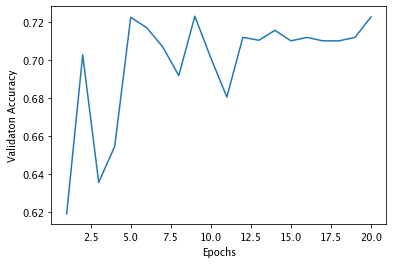

In [50]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Accuracy")
plt.show()

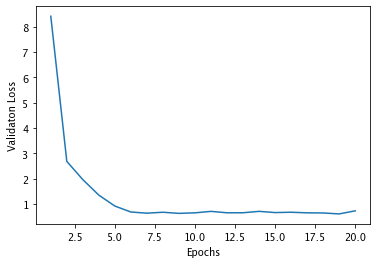

In [51]:
average_loss_history = [
    np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Validaton Loss")
plt.show()

In [18]:
test_acc

[0.7142857313156128,
 0.6857143044471741,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7222222089767456,
 0.7027027010917664,
 0.45945945382118225,
 0.7027027010917664,
 0.7027027010917664,
 0.7027027010917664,
 0.7027027010917664,
 0.6216216087341309]

In [81]:
average_acc = sum(test_acc)/len(test_acc)

In [299]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 6, 210, 64)        256       
                                                                 
 dropout_66 (Dropout)        (None, 6, 210, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 6, 210, 64)        12352     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 105, 64)       0         
 g2D)                                                            
                                                                 
 dropout_67 (Dropout)        (None, 6, 105, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 6, 105, 64)        12352     
                                                     

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)


y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
y_val = tf.keras.utils.to_categorical(y_val, num_output_class)

In [24]:
predictions = model.predict(X_train)

In [31]:
np.sum(predictions[0])

1.0973594

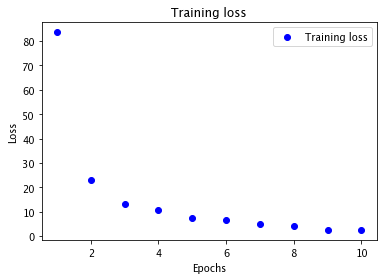

In [28]:
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

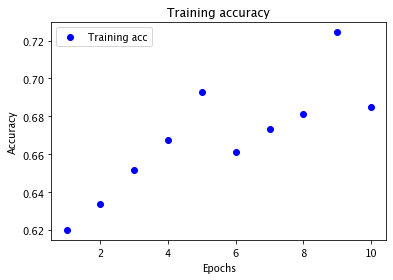

In [29]:
plt.clf()
acc = history_dict['accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title("Training accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Fragen

- Wie und wann Labels entfernen?